# Using PLD method to extract/correct NIRCam/SW photometry

We have used pixel-level decorrelation (PLD) method in past to obtain and correct photometry from TESS. I think the basic principles can also be applied to obtain corrected lightcurves of NIRCam/SW channel. The idea is to obtain lightcurves for each pixel in the aperture and then use that as decorrelation vector. 

Now, there would be >3000 points in a given aperture. So, what we will do is perform a PCA on these points and then only use first few principal components as regressors.

_Acknowledgements_: The algorithm used here is described in various literature, e.g., [Luger et al. 2016](https://www.doi.org/10.3847/0004-6256/152/4/100). The core code used in the present notebook was developed by Néstor Espinoza to extract photometry from TESS TPF files which can be found [here](https://github.com/nespinoza/PLD-TESS), which was then used by Jayshil A. Patel to extract lightcurves from [TESS/TICA data](https://github.com/Jayshil/tess-tica). We modified that code to work with JWST data in the present work.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import utils
import os
from tqdm import tqdm
from astropy.stats import mad_std
from astropy.timeseries import LombScargle
from astropy import units as u
import itertools

In [2]:
visit = 'NRCSW'

p1 = '/'.join(os.getcwd().split('/')[:-1])
pin = p1 + '/RateInts/Corr_' + visit
pout = p1 + '/NRCSW/Outputs/' + visit

segs = []
for i in range(4):
    if i < 9:
        segs.append('00' + str(i+1))
    else:
        segs.append('0' + str(i+1))

aprad = 85.

Let's first gather our data products. To save memory we will only work with a small segment of data -- and even from that small segment we will later choose only an aperture with the radius of 45 pixels and work only on that data.

Let's first find an aperture mask. To do this, we would need centroids. Fortunately, I already have centroids from previous aperture photometry. I will take meadian centroids from that analysis here.

Row center: 166.3730 pix; Column center: 548.6932 pix
Total number of pixels in the aperture: 22705.0000 pixels


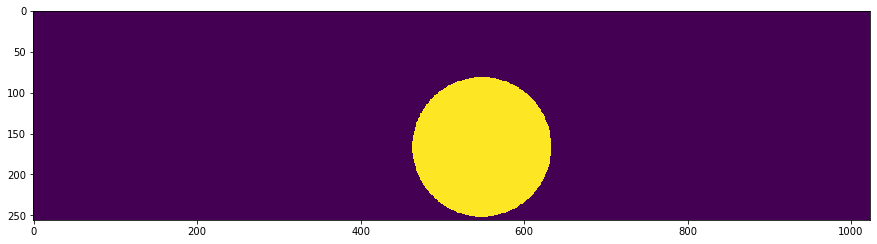

In [3]:
# Let's first find an aperture mask
cenr_all, cenc_all = np.loadtxt(pout + '/Photometry_' + visit + '_photutils.dat', usecols=(3,4), unpack=True)
cenr, cenc = np.nanmedian(cenr_all), np.nanmedian(cenc_all)

print('Row center: {:.4f} pix; Column center: {:.4f} pix'.format(cenr, cenc))

example_data = np.load(pin + '/Corrected_data_seg001.npy')
example_errs = np.load(pin + '/Corrected_errors_seg001.npy')

example_data, example_errs = np.nanmedian(example_data, axis=0), np.nanmedian(example_errs, axis=0)

_, _, aperture_mask = utils.aperture_mask(image=example_data, err=example_errs, cen_r=cenr, cen_c=cenc, rad=aprad)

print('Total number of pixels in the aperture: {:.4f} pixels'.format(np.sum(aperture_mask)))

# Let's plot the aperture mask
plt.figure(figsize=(15,5))
plt.imshow(aperture_mask, interpolation='None')

Okay, so the yellow region is our aperture; we now want to extract aperture photometry from this region along with pixel fluxes (that is lightcurve on each pixels inside the aperture).

Let's first extract the aperture photometry from this _fixed_ aperture.

100%|██████████| 4/4 [00:00<00:00,  6.73it/s]


Text(0, 0.5, 'Relative flux')

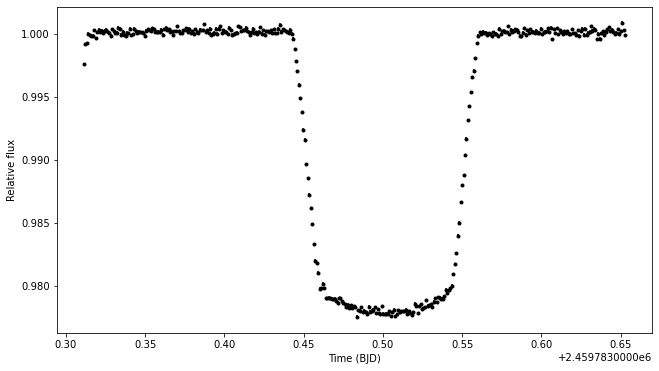

In [4]:
tim, fl, fle = np.array([]), np.array([]), np.array([])
for i in tqdm(range(len(segs))):
    # Loading and saving the times
    times_bjd = np.load(pin + '/Times_bjd_seg' + segs[i] + '.npy')
    tim = np.hstack((tim, times_bjd))

    # Loading the data
    corr_data = np.load(pin + '/Corrected_data_seg' + segs[i] + '.npy')
    corr_errs = np.load(pin + '/Corrected_errors_seg' + segs[i] + '.npy')
    # And extracting the aperture photometry
    for j in range(corr_data.shape[0]):
        ap_data, ap_err = corr_data[j,:,:]*aperture_mask, corr_errs[j,:,:]*aperture_mask
        fl, fle = np.hstack((fl, np.sum(ap_data))), np.hstack((fle, np.sqrt(np.sum(ap_err**2))))

tim = tim + 2400000.5

# And plotting the photometry
plt.figure(figsize=(16/1.5, 9/1.5))
plt.errorbar(tim, fl/np.median(fl), yerr=fle/np.median(fl), fmt='.', c='k')
plt.xlabel('Time (BJD)')
plt.ylabel('Relative flux')

As I already knew from ERS paper ([Ahrer et al. 2023](https://www.nature.com/articles/s41586-022-05590-4)), there are no jump events in the lightcurve. Our exercise here is to see that we do not detect any event in PCs.

Now, let's store the pixel fluxes (i.e., lightcurves at each pixel inside the aperture).

In [5]:
pixel_fluxes = np.zeros((len(tim), int(np.sum(aperture_mask))))

# Location of aperture pixels
idxr, idxc = np.where(aperture_mask == 1)

# First, saving all data in a single big array
corr_data0 = np.load(pin + '/Corrected_data_seg' + segs[0] + '.npy')
for i in tqdm(range(len(segs)-1)):
    cor1 = np.load(pin + '/Corrected_data_seg' + segs[i+1] + '.npy')
    corr_data0 = np.vstack((corr_data0, cor1))

# And, now saving pixel fluxes
for i in tqdm(range(len(idxr))):
    pixel_fluxes[:,i] = corr_data0[:,idxr[i],idxc[i]]

100%|██████████| 22705/22705 [00:00<00:00, 64409.92it/s]


Okay, so now we have an array of pixel fluxes, we can use them as regressors to detrend our photometry. We first attempt to use _all_ 22705 vectors as regressors. This is definately too much, but I just want to see if they can explain those jumps or not.

(Ideally we want to use only out-of-transit data points to model the trends, but as a first analysis this is okay. Furthermore, in the end, we will perform a full analysis using PCs as a regressors in lightcurve fitting. So, we do not need to worry about this right now.)

Basically, we want to model the total flux as, $F(t) = A + \Sigma_i a_i \hat{P}_i (t)$, where $\hat{P} \equiv P_i(t) / \Sigma_i P_i(t)$ and $A$ is the baseline flux.

In [6]:
# First defining Phat
Phat = np.zeros(pixel_fluxes.shape)
Psum = np.sum(pixel_fluxes,axis=1)

for i in range(Phat.shape[0]):
    Phat[i,:] = pixel_fluxes[i,:]/Psum[i]

# Regress PLD on all datapoints. Add a matrix of ones to account for the A coefficient:
X = np.vstack(( np.ones(Phat.shape[0]), Phat.T ))

# Perform linear regression to obtain coefficients on out-of-transit data:
result = np.linalg.lstsq(X.T, fl, rcond=None)
coeffs = result[0]

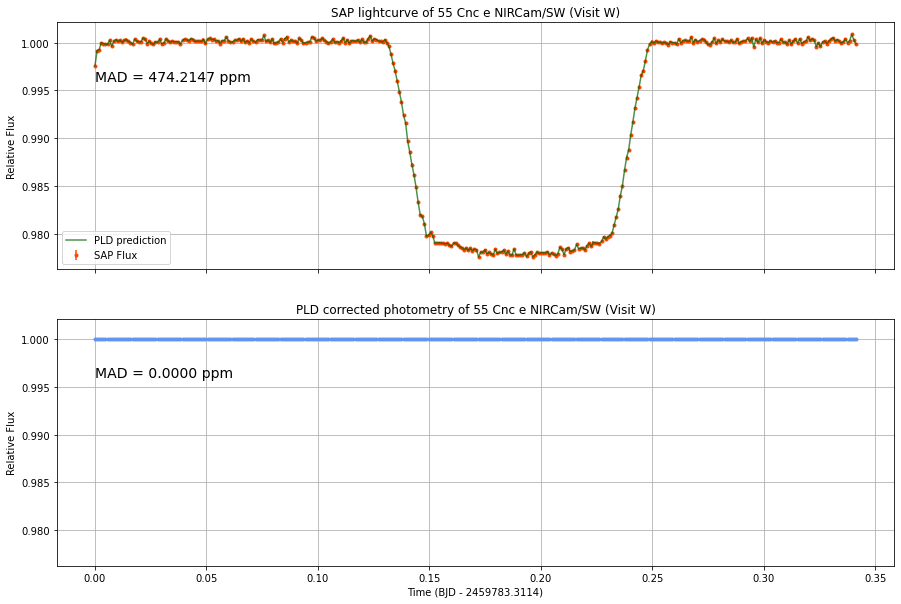

In [7]:
prediction = np.dot(coeffs, X)

fig, axs = plt.subplots(2, 1, figsize=(15,10), sharex=True, sharey=True)

axs[0].errorbar(tim-tim[0], fl/np.median(fl), yerr=fle/np.median(fl), fmt='.', c='orangered', label='SAP Flux')
axs[0].plot(tim-tim[0], prediction/np.median(fl), c='darkgreen', label='PLD prediction',alpha=0.7, zorder=10)
axs[0].set_ylabel('Relative Flux')
axs[0].set_title('SAP lightcurve of 55 Cnc e NIRCam/SW (Visit ' + str(visit[-1]) + ')')
axs[0].text(0., 0.996, 'MAD = {:.4f} ppm'.format(mad_std(fl/np.median(fl))*1e6), fontsize=14)
axs[0].legend(loc='best')
axs[0].grid()

axs[1].errorbar(tim-tim[0], fl/prediction, yerr=fle/prediction, fmt='.', c='cornflowerblue')
axs[1].set_xlabel('Time (BJD - {:.4f})'.format(tim[0]))
axs[1].set_ylabel('Relative Flux')
axs[1].set_title('PLD corrected photometry of 55 Cnc e NIRCam/SW (Visit ' + str(visit[-1]) + ')')
axs[1].text(0., 0.996, 'MAD = {:.4f} ppm'.format(mad_std(fl/prediction)*1e6), fontsize=14)
axs[1].grid()
#axs[1].set_xlim([22.38,22.42])

plt.savefig(pout + '/Figures_PCA/Without_PCA.png', dpi=500, facecolor='white')

Hahaha! Since there are very few points, the PLD prediction literally went through each datapoint -- very bad model. That's why PCA is needed.

Why else we need PCA? Well, we can look at correlations among the pixel lightcurves below:

Text(0, 0.5, 'Element $j$')

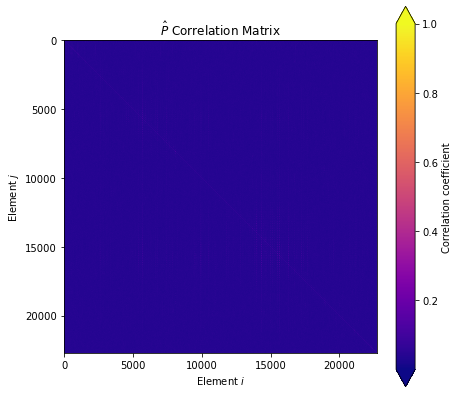

In [8]:
CorrelationMatrix = np.abs(np.corrcoef(Phat.T))

plt.figure(figsize=(7,7))
plt.title('$\hat{P}$ Correlation Matrix')
im = plt.imshow(CorrelationMatrix, cmap='plasma')
cbar = plt.colorbar(im, extend='both',label='Correlation coefficient')
plt.xlabel('Element $i$')
plt.ylabel('Element $j$')

Okay, this is unfortunate -- since there are too many datapoints we cannot see anything in above plot. But believe me, if we were able to see the plot above we could have seen that off-diagonal elements in above matrix are non-zero; meaning that there is too many extra information in the matrix. Our plan is to perform PCA to remove this extra information.

In [9]:
def standarize_data(input_data):
    """
    Standarize the dataset
    """
    output_data = np.copy(input_data)
    averages = np.median(input_data,axis=1)
    for i in range(len(averages)):
        sigma = mad_std(output_data[i,:])
        output_data[i,:] = output_data[i,:] - averages[i]
        output_data[i,:] = output_data[i,:]/sigma
    return output_data

def classic_PCA(Input_Data, standarize = True):
    """  
    classic_PCA function
    Description
    This function performs the classic Principal Component Analysis on a given dataset.
    """
    if standarize:
        Data = standarize_data(Input_Data)
    else:
        Data = np.copy(Input_Data)
    eigenvectors_cols,eigenvalues,eigenvectors_rows = np.linalg.svd(np.cov(Data))
    idx = eigenvalues.argsort()
    eigenvalues = eigenvalues[idx[::-1]]
    eigenvectors_cols = eigenvectors_cols[:,idx[::-1]]
    eigenvectors_rows = eigenvectors_rows[idx[::-1],:]
    # Return: V matrix, eigenvalues and the principal components.
    return eigenvectors_rows,eigenvalues,np.dot(eigenvectors_rows,Data)

V, eigenvalues, PCA = classic_PCA(Phat.T)

And let's see how the correlation matrix looks like,

Text(0, 0.5, 'Element $j$')

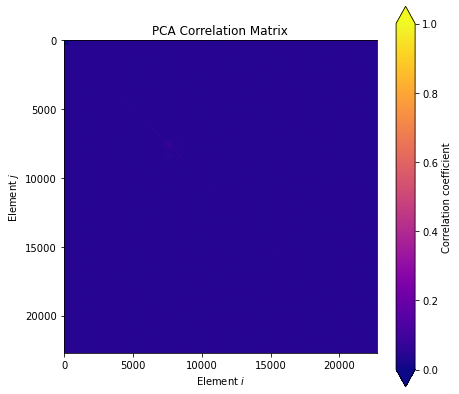

In [10]:
PCACorrelationMatrix = np.abs(np.corrcoef(PCA))

plt.figure(figsize=(7,7))
plt.title('PCA Correlation Matrix')
im = plt.imshow(PCACorrelationMatrix,cmap='plasma')
cbar = plt.colorbar(im, extend='both',label='Correlation coefficient')
plt.xlabel('Element $i$')
plt.ylabel('Element $j$')

It's almost diagonalised (of course it is hard to see, the matrix is very big (5201x5201)).

Let's visualise the first 10 eigenvectors:

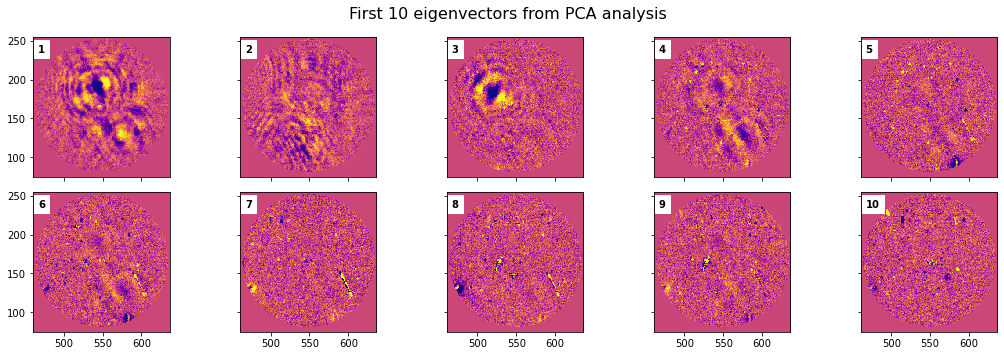

In [17]:
comps = 0

fig, axs = plt.subplots(nrows=2, ncols=5, figsize=(15, 5), sharex=True, sharey=True)
for r in range(axs.shape[0]):
    for c in range(axs.shape[1]):
        eg_vec = np.zeros(aperture_mask.shape)
        for k in range(len(idxr)):
            eg_vec[idxr[k], idxc[k]] = V[comps, k]
        im = axs[r,c].imshow(eg_vec, interpolation='none', cmap='plasma')
        axs[r,c].set_xlim([np.min(idxc)-3,np.max(idxc)+3])
        axs[r,c].set_ylim([75,255])
        axs[r,c].text(np.min(idxc)+3, 235, comps+1, fontweight='bold', backgroundcolor='white')
        min1 = np.nanmedian(V[comps,:]) - 4*mad_std(V[comps,:])
        max1 = np.nanmedian(V[comps,:]) + 4*mad_std(V[comps,:])
        im.set_clim([min1, max1])
        comps = comps + 1
fig.suptitle('First 10 eigenvectors from PCA analysis', fontsize=16)
plt.tight_layout()
plt.savefig(pout + '/Figures_PCA/Eigenvectors.png', dpi=500, facecolor='white')

Let's have a look at eigenvalues (we want to select only first few vectors)

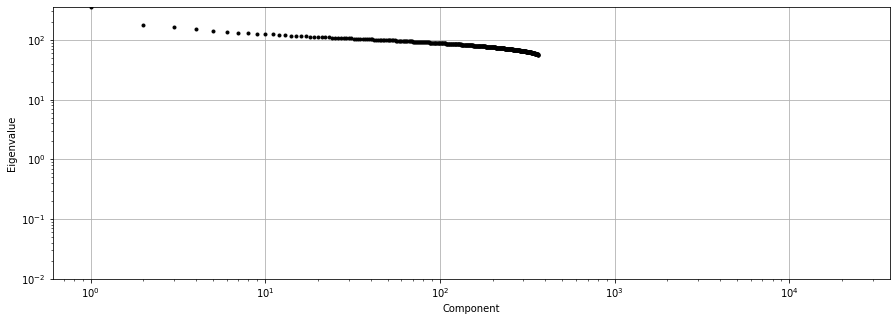

In [18]:
plt.figure(figsize=(15,5))
plt.errorbar(np.arange(len(eigenvalues))+1, eigenvalues, fmt='.', c='k')
plt.xlabel('Component')
plt.ylabel('Eigenvalue')
plt.xscale('log')
plt.yscale('log')
plt.ylim([1e-2,np.max(eigenvalues)])
plt.grid()

The eigenvalue curve mostly flattens after first 10 components. So, in the following analysis, we will just use first 10 components.

Let's first analytically compute the PLD prediction model before doing a more thorough analysis.

In [19]:
X = np.vstack(( np.ones(len(fl)), PCA[:10,:] ))
# Fit:
result = np.linalg.lstsq(X.T, fl, rcond=None)
coeffs = result[0]

prediction = np.dot(coeffs, X)

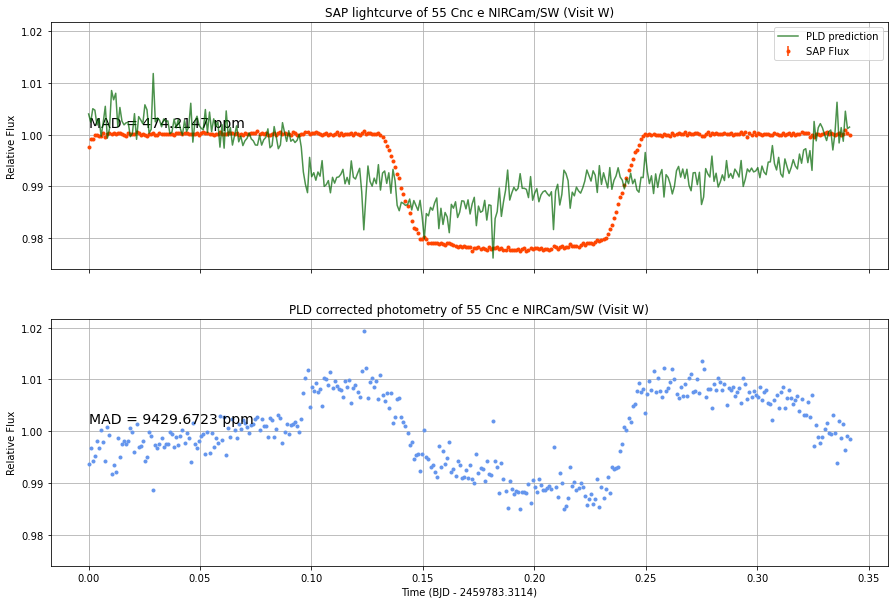

In [20]:
fig, axs = plt.subplots(2, 1, figsize=(15,10), sharex=True, sharey=True)

axs[0].errorbar(tim-tim[0], fl/np.median(fl), yerr=fle/np.median(fl), fmt='.', c='orangered', label='SAP Flux')
axs[0].plot(tim-tim[0], prediction/np.median(fl), c='darkgreen', label='PLD prediction',alpha=0.7, zorder=10)
axs[0].set_ylabel('Relative Flux')
axs[0].set_title('SAP lightcurve of 55 Cnc e NIRCam/SW (Visit ' + str(visit[-1]) + ')')
axs[0].text(0., 1.0015, 'MAD = {:.4f} ppm'.format(mad_std(fl/np.median(fl))*1e6), fontsize=14)
axs[0].legend(loc='best')
axs[0].grid()

axs[1].errorbar(tim-tim[0], fl/prediction, yerr=fle/prediction, fmt='.', c='cornflowerblue')
axs[1].set_xlabel('Time (BJD - {:.4f})'.format(tim[0]))
axs[1].set_ylabel('Relative Flux')
axs[1].set_title('PLD corrected photometry of 55 Cnc e NIRCam/SW (Visit ' + str(visit[-1]) + ')')
axs[1].text(0., 1.0015, 'MAD = {:.4f} ppm'.format(mad_std(fl/prediction)*1e6), fontsize=14)
axs[1].grid()
#axs[1].set_xlim([22.38,22.42])

plt.savefig(pout + '/Figures_PCA/With_PCA.png', dpi=500, facecolor='white')

This is too bad! It looks like PLD won't work on this dataset!

Before going into the 2nd order PLD, let's look at how first 10 components of PCA looks like

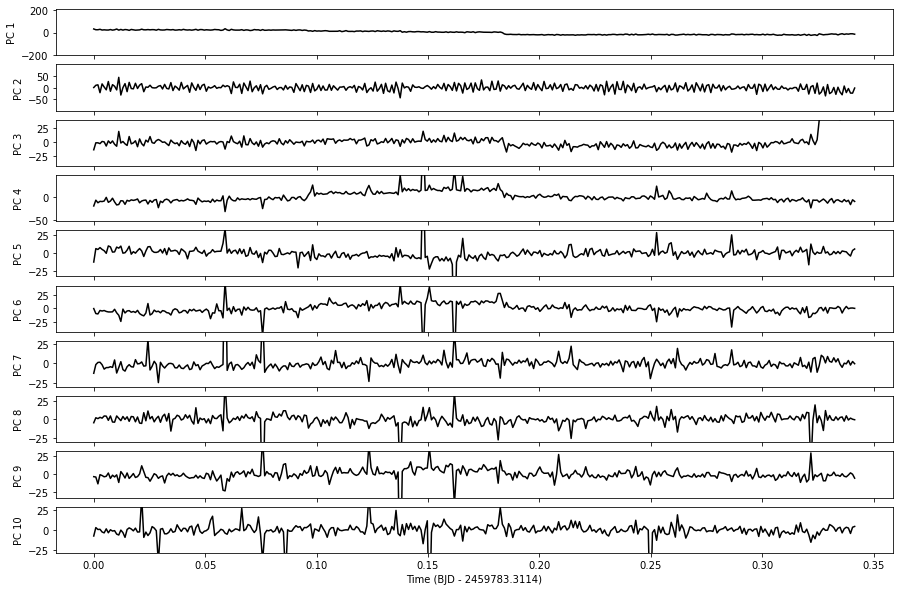

In [24]:
fig, axs = plt.subplots(nrows=10, ncols=1, figsize=(15,10), sharex=True)
for i in range(10):
    axs[i].plot(tim - tim[0], PCA[i,:], 'k-')
    axs[i].set_ylabel('PC ' + str(i+1))
    med, std = np.nanmedian(PCA[i,:]), mad_std(PCA[i,:])
    axs[i].set_ylim([med-7*std, med+7*std])
plt.xlabel('Time (BJD - {:.4f})'.format(tim[0]))

np.save(pout + '/PCs.npy', PCA)
plt.savefig(pout + '/Figures_PCA/PCs.png', dpi=500, facecolor='white')

Are we seeing that high frequency noise in the second component? Let's look at its PSD:

Maximum power at the time: 3.3950 min


/Users/japa6985/opt/anaconda3/envs/jwst/lib/python3.9/site-packages/astropy/units/quantity.py:666: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


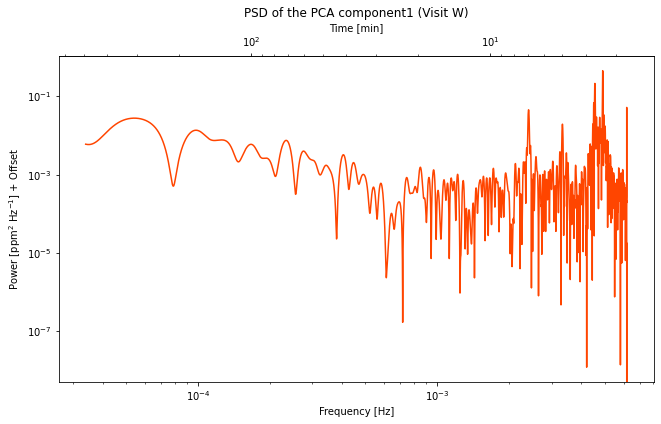

In [25]:
nComp = 1

tim1 = tim*24*60*60*u.second

min_frequency = 1. / (np.ptp(tim1))   # inverse clock-time of a column
max_frequency = (1. / (tim1[1]-tim1[0])) * 0.5
freq = np.linspace(min_frequency, max_frequency, 100000)

pca4 = 1e6*PCA[nComp,:]*u.dimensionless_unscaled
power = LombScargle(tim1,pca4).power(frequency=freq)

freq1 = freq[np.argsort(power.value)[-1]]
per2 = 1/freq1
per3 = per2.to(u.day)

print('Maximum power at the time: {:.4f}'.format(per3.to(u.min)))

def freq2min(x):
    x = 1/x * u.s
    return x.to(u.min).value

def min2freq(x):
    x = x*u.min
    x = 1/x
    return x.to(u.s**-1).value

# Making the plot:
fig, axs = plt.subplots(figsize=(16/1.5, 9/1.5))

axs.plot(freq.value, power.value, color='orangered')
#axs.axvline(freq1.value, ls='--', c='darkgreen')
axs.set_xscale('log')
axs.set_yscale('log')

axs.set_xlabel(r'Frequency [Hz]')
axs.set_ylabel(r'Power [ppm$^2$ Hz$^{-1}$] + Offset')
axs.set_title('PSD of the PCA component' + str(nComp) + ' (Visit ' + visit[-1] + ')')

secax = axs.secondary_xaxis('top', functions=(freq2min, min2freq))
secax.set_xlabel(r'Time [min]')

#plt.xlim([4e-3, 6e-3])

plt.savefig(pout + '/Figures_PCA/PSD.png', dpi=500, facecolor='white')

Ohh my, that's again! This is the same period that we observed in 55 Cnc data but with lower amplitude.